In [1]:
import numpy as np
import torch
import pickle
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torchvision.datasets as datasets
import torch.distributions.normal as Normal
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
import timm
import torch.optim as optim
from tqdm import trange, tqdm
from sklearn.preprocessing import MultiLabelBinarizer

Visualize the Data


In [2]:
datax = np.load("X.npy")
datay = np.load("Y.npy")



In [3]:
print(datax.shape,datay.shape)

(22801, 128, 128, 3) (22801, 1)


['please']


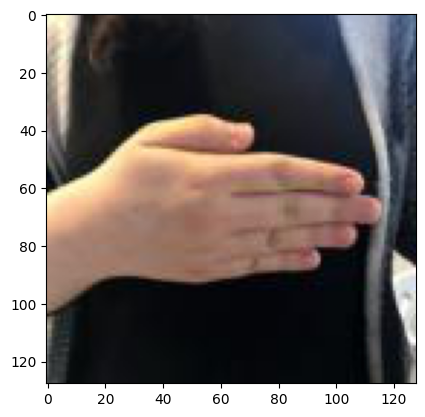

In [4]:
import matplotlib.pyplot as plt
index = 225
plt.imshow(datax[index])
print(datay[index])

Create One Hot Encoding for each of the possible labels


In [11]:
labelsSet = np.unique(datay) 
labelToTensor = {}
for i,label in enumerate(labelsSet):
    labelToTensor[label] = i

print(labelToTensor)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'NULL': 10, 'a': 11, 'b': 12, 'bye': 13, 'c': 14, 'd': 15, 'e': 16, 'good': 17, 'good morning': 18, 'hello': 19, 'little bit': 20, 'no': 21, 'pardon': 22, 'please': 23, 'project': 24, 'whats up': 25, 'yes': 26}


In [13]:
labelEncode = []
for label in datay:
    #print(type(str(label[0])))
    target = labelToTensor.get(label[0])
    #print(target)
    labelEncode.append(target)
labelEncode = np.array(labelEncode)
labelEncodeTensor = torch.from_numpy(labelEncode)
labelEncodeTensor = labelEncodeTensor.long()
print(labelEncodeTensor)

tensor([23, 23, 23,  ...,  5,  5,  5])


In [14]:
target_onehot = torch.zeros(datay.shape[0],27)

In [15]:
target_onehot.shape

torch.Size([22801, 27])

In [16]:
label_one_hot = target_onehot.scatter(1,labelEncodeTensor.unsqueeze(1), 1.0)
label_one_hot = label_one_hot.numpy()

In [17]:
print(label_one_hot[0])
print(labelEncode[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0.]
23


In [18]:
X_train, X_test, y_train, y_test = train_test_split(datax, label_one_hot, test_size=0.2, random_state=42)

Create the data loader

In [19]:
class ASL(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, images,labels):
        self.dataImages = images
        self.dataLabels = labels
        print(len(self.dataImages))
    def __len__(self):
        return len(self.dataImages)

    def __getitem__(self, idx):
        image= self.dataImages[idx]
        label = self.dataLabels[idx]
        #image = image.transpose()
        #print(imagePath)
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        #print(image.shape)
        img_tensor = transform(image)
        label = torch.from_numpy(label)
        return img_tensor,label
    

In [20]:
X_train, X_test, y_train, y_test
ASLDataTrain = ASL(X_train,y_train)
ASLDataTest = ASL(X_test,y_test)
trainloader = DataLoader(ASLDataTrain, batch_size=64,shuffle=True)
testloader = DataLoader(ASLDataTest,batch_size=64,shuffle=False)

18240
4561


In [21]:
it = iter(trainloader)
first = next(it)
first[1].dtype

torch.float32

In [22]:
model = timm.create_model('resnet18',num_classes=27)
x     = torch.randn(1, 3, 128, 128)
model(x).shape

torch.Size([1, 27])

In [39]:
model = timm.create_model('resnet18',num_classes=27)
use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")
print(device)
lr=0.00001
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
BCELoss= torch.nn.CrossEntropyLoss()

cuda:0


In [40]:
len(ASLDataTest)

4561

In [41]:
model.to(device)
for epoch in trange(0, 50, leave=False):
    model.train()
    for i, (images,labels) in enumerate(tqdm(trainloader, leave=False)):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        #VAE loss
        loss = BCELoss(output,labels)
    
        loss.backward()
        optimizer.step()

    model.eval()
    valAccuracy = 0
    with torch.no_grad():
        for i, (images,labels) in enumerate(tqdm(testloader)):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)

            testLoss = BCELoss(output,labels)
            for guess,target in zip(output,labels):
                if(torch.argmax(guess) == torch.argmax(target)):
                    valAccuracy +=1

    valAccuracy = valAccuracy/(len(ASLDataTest))

    print("Train Loss",loss)
    print("Test loss", testLoss)
    print("Val Accuracy", valAccuracy)
    #In eval mode the model will use mu as the encoding instead of sampling from the distribution
    # vae_net.eval()
    # with torch.no_grad():
    #     recon_img, _, _ = vae_net(test_images.to(device))
    #     img_cat = torch.cat((recon_img.cpu(), test_images), 2)
        
    #     vutils.save_image(img_cat,
    #                       "%s/%s/%s_%d.png" % (save_dir, "Results" , model_name, image_size),
    #                       normalize=True)

  2%|▏         | 1/50 [00:09<07:34,  9.29s/it]

Train Loss tensor(3.1634, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(3.4240, device='cuda:0')
Val Accuracy 0.0714755536066652


  4%|▍         | 2/50 [00:18<07:11,  8.99s/it]

Train Loss tensor(3.1284, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(3.2896, device='cuda:0')
Val Accuracy 0.1427318570488928


  6%|▌         | 3/50 [00:26<06:45,  8.62s/it]

Train Loss tensor(2.8603, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(3.1181, device='cuda:0')
Val Accuracy 0.22692392019294014


  8%|▊         | 4/50 [00:34<06:30,  8.48s/it]

Train Loss tensor(2.4530, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(2.8129, device='cuda:0')
Val Accuracy 0.2661696996272747


 10%|█         | 5/50 [00:42<06:17,  8.39s/it]

Train Loss tensor(2.2571, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(2.4702, device='cuda:0')
Val Accuracy 0.36329752247314184


 12%|█▏        | 6/50 [00:50<06:05,  8.30s/it]

Train Loss tensor(1.8522, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(2.4508, device='cuda:0')
Val Accuracy 0.3372067529050647


 14%|█▍        | 7/50 [00:59<05:55,  8.27s/it]

Train Loss tensor(1.6645, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(1.9096, device='cuda:0')
Val Accuracy 0.5371629028721772


 16%|█▌        | 8/50 [01:07<05:47,  8.27s/it]

Train Loss tensor(1.3433, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(1.5702, device='cuda:0')
Val Accuracy 0.5858364393773295


 18%|█▊        | 9/50 [01:15<05:39,  8.28s/it]

Train Loss tensor(1.0060, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(1.3929, device='cuda:0')
Val Accuracy 0.6616969962727473


 20%|██        | 10/50 [01:24<05:34,  8.37s/it]

Train Loss tensor(0.8198, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(1.0495, device='cuda:0')
Val Accuracy 0.7296645472484105


 22%|██▏       | 11/50 [01:32<05:25,  8.34s/it]

Train Loss tensor(0.7862, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.9702, device='cuda:0')
Val Accuracy 0.7816268362201272


 24%|██▍       | 12/50 [01:40<05:15,  8.29s/it]

Train Loss tensor(0.5616, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.8243, device='cuda:0')
Val Accuracy 0.8110063582547687


 26%|██▌       | 13/50 [01:48<05:06,  8.29s/it]

Train Loss tensor(0.4079, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.6388, device='cuda:0')
Val Accuracy 0.8296426222319667


 28%|██▊       | 14/50 [01:57<04:58,  8.29s/it]

Train Loss tensor(0.3851, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.5874, device='cuda:0')
Val Accuracy 0.8535408901556676


 30%|███       | 15/50 [02:05<04:49,  8.28s/it]

Train Loss tensor(0.2050, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.5980, device='cuda:0')
Val Accuracy 0.8831396623547467


 32%|███▏      | 16/50 [02:13<04:40,  8.26s/it]

Train Loss tensor(0.2428, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.3930, device='cuda:0')
Val Accuracy 0.9063801797851349


 34%|███▍      | 17/50 [02:22<04:32,  8.27s/it]

Train Loss tensor(0.2500, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.3352, device='cuda:0')
Val Accuracy 0.9217276912957685


 36%|███▌      | 18/50 [02:30<04:24,  8.25s/it]

Train Loss tensor(0.1292, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.2205, device='cuda:0')
Val Accuracy 0.9283051962288972


 38%|███▊      | 19/50 [02:38<04:15,  8.23s/it]

Train Loss tensor(0.1579, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.1569, device='cuda:0')
Val Accuracy 0.9304976978732734


 40%|████      | 20/50 [02:46<04:06,  8.21s/it]

Train Loss tensor(0.0913, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.1094, device='cuda:0')
Val Accuracy 0.9348827011620259


 42%|████▏     | 21/50 [02:54<03:57,  8.19s/it]

Train Loss tensor(0.0532, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.1390, device='cuda:0')
Val Accuracy 0.945845209383907


 44%|████▍     | 22/50 [03:02<03:50,  8.22s/it]

Train Loss tensor(0.0205, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.1203, device='cuda:0')
Val Accuracy 0.9508879631659723


 46%|████▌     | 23/50 [03:11<03:43,  8.26s/it]

Train Loss tensor(0.0343, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.0849, device='cuda:0')
Val Accuracy 0.9469414602060952


 48%|████▊     | 24/50 [03:19<03:34,  8.24s/it]

Train Loss tensor(0.0157, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.1328, device='cuda:0')
Val Accuracy 0.9497917123437842


 50%|█████     | 25/50 [03:27<03:25,  8.23s/it]

Train Loss tensor(0.0323, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.0332, device='cuda:0')
Val Accuracy 0.9585617189212892


 52%|█████▏    | 26/50 [03:36<03:17,  8.24s/it]

Train Loss tensor(0.0090, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.0247, device='cuda:0')
Val Accuracy 0.964481473361105


 54%|█████▍    | 27/50 [03:44<03:09,  8.23s/it]

Train Loss tensor(0.0082, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.0563, device='cuda:0')
Val Accuracy 0.9568077176057882


 56%|█████▌    | 28/50 [03:52<03:02,  8.29s/it]

Train Loss tensor(0.0201, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.0119, device='cuda:0')
Val Accuracy 0.9570269677702258


 58%|█████▊    | 29/50 [04:01<02:55,  8.34s/it]

Train Loss tensor(0.0114, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.0610, device='cuda:0')
Val Accuracy 0.9572462179346635


 60%|██████    | 30/50 [04:09<02:47,  8.40s/it]

Train Loss tensor(0.0029, device='cuda:0', grad_fn=<DivBackward1>)
Test loss tensor(0.0244, device='cuda:0')
Val Accuracy 0.9633852225389169


 39%|███▉      | 28/72 [00:00<00:00, 51.99it/s]


KeyboardInterrupt: 